 # Analyse Statique

 Cette section est dédiée à l’analyse exploratoire statique de nos données météorologiques.



 L’objectif est de caractériser les variables disponibles indépendamment de leur dimension temporelle, afin d’évaluer leur qualité, leur distribution et leurs relations mutuelles.

 Nous cherchons ici à :

     - Comprendre la structure générale du jeu de données (types, valeurs manquantes, ordres de grandeur) ;

     - Analyser les distributions et asymétries des variables physiques (température, humidité, vent, précipitations, etc.) ;

     - Détecter d’éventuelles valeurs aberrantes et vérifier leur cohérence physique ;

     - Étudier les corrélations internes et leur pertinence vis-à-vis de la variable cible (temperature_2m).



 Ces explorations permettront de valider la cohérence globale du dataset et de repérer d’éventuelles redondances ou transformations nécessaires pour la suite du projet.

 # I - Analyses préliminaires :

 # 1. Import des librairies

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pls
import seaborn as sns
from calendar import month_abbr
from calendar import day_abbr
sns.set_theme(style="darkgrid")

import warnings
warnings.filterwarnings("ignore")

# 2. Lecture du fichier

In [20]:
data_path = "data/hourly_data.csv"
df = pd.read_csv(data_path)

# 3. Aperçu général 

In [21]:
print("Nombre de lignes :", df.shape[0])
print("Nombre de colonnes :", df.shape[1])

display(df.head())

Nombre de lignes : 226320
Nombre de colonnes : 36


,time,temperature_2m,relative_humidity_2m,apparent_temperature,dew_point_2m,precipitation,rain,snowfall,snow_depth,wind_speed_100m,...,soil_temperature_100_to_255cm,soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,soil_moisture_28_to_100cm,soil_moisture_100_to_255cm,wet_bulb_temperature_2m,boundary_layer_height,total_column_integrated_water_vapour,is_day,sunshine_duration
0,2000-01-01 00:00:00,6.0,97,4.0,5.5,0.0,0.0,0.0,0.01,14.0,...,10.8,0.414,0.419,0.417,0.359,5.6,115.0,15.6,0,0.0
1,2000-01-01 01:00:00,6.0,96,3.8,5.4,0.0,0.0,0.0,0.01,14.9,...,10.8,0.414,0.419,0.417,0.359,5.5,100.0,16.5,0,0.0
2,2000-01-01 02:00:00,5.9,96,3.8,5.3,0.0,0.0,0.0,0.01,14.7,...,10.8,0.414,0.418,0.417,0.359,5.4,105.0,16.7,0,0.0
3,2000-01-01 03:00:00,6.0,96,3.8,5.3,0.0,0.0,0.0,0.01,14.6,...,10.8,0.414,0.418,0.417,0.359,5.5,110.0,16.9,0,0.0
4,2000-01-01 04:00:00,6.1,96,3.9,5.5,0.0,0.0,0.0,0.01,15.5,...,10.7,0.413,0.418,0.417,0.359,5.6,130.0,17.3,0,0.0


# 4. Infos générales 

In [22]:
print("\n=== Informations générales sur le dataset ===")
df.info()


=== Informations générales sur le dataset ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226320 entries, 0 to 226319
Data columns (total 36 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   time                                  226320 non-null  object 
 1   temperature_2m                        226320 non-null  float64
 2   relative_humidity_2m                  226320 non-null  int64  
 3   apparent_temperature                  226320 non-null  float64
 4   dew_point_2m                          226320 non-null  float64
 5   precipitation                         226320 non-null  float64
 6   rain                                  226320 non-null  float64
 7   snowfall                              226320 non-null  float64
 8   snow_depth                            226320 non-null  float64
 9   wind_speed_100m                       226320 non-null  float64
 10  wind_speed_10m       

 # 5. Traitement des valeurs manquantes

In [23]:
missing = df.isna().mean() * 100
display(missing[missing > 0].sort_values(ascending=False))

boundary_layer_height                   1.930011
total_column_integrated_water_vapour    1.930011
dtype: float64

 Deux variables présentent un taux de valeurs manquantes inférieur à 2 %, ce qui reste faible.

 Plusieurs approches peuvent être envisagées :

          - Suppression des lignes concernées : peut conduire à une légère perte d’information temporelle.

          - Imputation par interpolation temporelle : méthode recommandée pour la modélisation, car elle préserve la continuité du signal et la cohérence temporelle du dataset 

          - Exclusion ultérieure des variables : si ces colonnes s’avèrent peu informatives lors de la modélisation, elles pourront être retirées sans impact sur la structure globale.

 Nous allons analyser plus en détail la distribution temporelle des valeurs manquantes afin de choisir la méthode la plus cohérente.

 # Localisation des valeurs manquantes

In [24]:
missing_rows = df[df['boundary_layer_height'].isna() | df['total_column_integrated_water_vapour'].isna()]
print("Nombre de lignes concernées :", len(missing_rows))
display(missing_rows.head())

Nombre de lignes concernées : 4368


,time,temperature_2m,relative_humidity_2m,apparent_temperature,dew_point_2m,precipitation,rain,snowfall,snow_depth,wind_speed_100m,...,soil_temperature_100_to_255cm,soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,soil_moisture_28_to_100cm,soil_moisture_100_to_255cm,wet_bulb_temperature_2m,boundary_layer_height,total_column_integrated_water_vapour,is_day,sunshine_duration
210385,2024-01-01 01:00:00,7.3,76,1.8,3.3,0.0,0.0,0.0,0.0,43.9,...,12.6,0.367,0.367,0.360,0.274,4.9,NaN,NaN,0,0.0
210386,2024-01-01 02:00:00,7.3,72,1.8,2.5,0.0,0.0,0.0,0.0,42.5,...,12.6,0.367,0.368,0.361,0.274,4.6,NaN,NaN,0,0.0
210387,2024-01-01 03:00:00,7.1,73,1.7,2.5,0.0,0.0,0.0,0.0,42.4,...,12.6,0.366,0.368,0.361,0.274,4.5,NaN,NaN,0,0.0
210388,2024-01-01 04:00:00,6.9,74,1.5,2.5,0.0,0.0,0.0,0.0,41.8,...,12.6,0.366,0.367,0.361,0.274,4.4,NaN,NaN,0,0.0
210389,2024-01-01 05:00:00,6.8,75,1.5,2.6,0.0,0.0,0.0,0.0,41.3,...,12.6,0.366,0.367,0.361,0.274,4.4,NaN,NaN,0,0.0


In [25]:
missing_rows = df[df['boundary_layer_height'].isna() | df['total_column_integrated_water_vapour'].isna()]

print(f" Nombre total de lignes avec des valeurs manquantes : {len(missing_rows)}")
print("\nExemples de lignes concernées :")
display(missing_rows.head())

print("\n=== Périodes où les valeurs manquent ===")
missing_periods = missing_rows[['time']].sort_values(by='time')
display(missing_periods.head(10))
display(missing_periods.tail(10))

 Nombre total de lignes avec des valeurs manquantes : 4368

Exemples de lignes concernées :


,time,temperature_2m,relative_humidity_2m,apparent_temperature,dew_point_2m,precipitation,rain,snowfall,snow_depth,wind_speed_100m,...,soil_temperature_100_to_255cm,soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,soil_moisture_28_to_100cm,soil_moisture_100_to_255cm,wet_bulb_temperature_2m,boundary_layer_height,total_column_integrated_water_vapour,is_day,sunshine_duration
210385,2024-01-01 01:00:00,7.3,76,1.8,3.3,0.0,0.0,0.0,0.0,43.9,...,12.6,0.367,0.367,0.360,0.274,4.9,NaN,NaN,0,0.0
210386,2024-01-01 02:00:00,7.3,72,1.8,2.5,0.0,0.0,0.0,0.0,42.5,...,12.6,0.367,0.368,0.361,0.274,4.6,NaN,NaN,0,0.0
210387,2024-01-01 03:00:00,7.1,73,1.7,2.5,0.0,0.0,0.0,0.0,42.4,...,12.6,0.366,0.368,0.361,0.274,4.5,NaN,NaN,0,0.0
210388,2024-01-01 04:00:00,6.9,74,1.5,2.5,0.0,0.0,0.0,0.0,41.8,...,12.6,0.366,0.367,0.361,0.274,4.4,NaN,NaN,0,0.0
210389,2024-01-01 05:00:00,6.8,75,1.5,2.6,0.0,0.0,0.0,0.0,41.3,...,12.6,0.366,0.367,0.361,0.274,4.4,NaN,NaN,0,0.0



=== Périodes où les valeurs manquent ===


,time
210385,2024-01-01 01:00:00
210386,2024-01-01 02:00:00
210387,2024-01-01 03:00:00
210388,2024-01-01 04:00:00
210389,2024-01-01 05:00:00
210390,2024-01-01 06:00:00
210391,2024-01-01 07:00:00
210392,2024-01-01 08:00:00
210393,2024-01-01 09:00:00
210394,2024-01-01 10:00:00


,time
214743,2024-06-30 15:00:00
214744,2024-06-30 16:00:00
214745,2024-06-30 17:00:00
214746,2024-06-30 18:00:00
214747,2024-06-30 19:00:00
214748,2024-06-30 20:00:00
214749,2024-06-30 21:00:00
214750,2024-06-30 22:00:00
214751,2024-06-30 23:00:00
214752,2024-07-01 00:00:00


 #  Vérification de la distribution temporelle des valeurs manquantes :

In [26]:
missing_times = df.loc[
    df['boundary_layer_height'].isna() | df['total_column_integrated_water_vapour'].isna(),
    'time'
]
print("Période minimale :", missing_times.min())
print("Période maximale :", missing_times.max())

# Pour voir si elles sont continues ou dispersées
missing_times = pd.to_datetime(missing_times)
missing_gaps = missing_times.diff().dt.total_seconds().dropna()

print("\nDistribution des écarts temporels entre valeurs manquantes :")
display(missing_gaps.describe())


Période minimale : 2024-01-01 01:00:00
Période maximale : 2024-07-01 00:00:00

Distribution des écarts temporels entre valeurs manquantes :


count    4367.0
mean     3600.0
std         0.0
min      3600.0
25%      3600.0
50%      3600.0
75%      3600.0
max      3600.0
Name: time, dtype: float64

 Deux variables présentent environ 1,93 % de valeurs manquantes.

 L’analyse des timestamps montre que les lignes concernées sont contiguës à pas horaire (les écarts successifs entre deux valeurs manquantes sont toujours de 3600 s = 1 h).

 Cela indique des plages continues de valeurs manquantes, plutôt qu’une dispersion aléatoire dans le temps.

 Les données sont horodatées à une fréquence horaire régulière (en UTC ou Europe/Paris, à préciser selon la source).

 Aucune irrégularité de fréquence n’est observée sur la période étudiée.

 Pour préserver la cohérence temporelle du jeu de données et éviter de supprimer des observations, une interpolation temporelle linéaire (method="time") est appliquée sur ces colonnes.

 Cette méthode reconstruit les valeurs manquantes en suivant l’évolution locale des séries, sans extrapolation en dehors de la période observée.

 Cette approche permet de conserver un signal météorologique complet et régulier, nécessaire aux analyses temporelles et à la modélisation prédictive.

 Si, par la suite, ces variables s’avèrent peu contributives pour la prédiction, elles pourront être supprimées ou ignorées sans affecter la structure temporelle du dataset.

 # 7. Interpolation temporelle

In [27]:
# Conversion de la colonne 'time' en datetime
df['time'] = pd.to_datetime(df['time'])

# Mise en index temporel pour faciliter l'interpolation
df = df.set_index('time')

# Vérification du nombre de valeurs manquantes avant interpolation
print("Valeurs manquantes avant interpolation :")
print(df[['boundary_layer_height', 'total_column_integrated_water_vapour']].isna().sum())

# Interpolation temporelle pour remplir les valeurs manquantes
df['boundary_layer_height'] = df['boundary_layer_height'].interpolate(method='time')
df['total_column_integrated_water_vapour'] = df['total_column_integrated_water_vapour'].interpolate(method='time')

# Vérification après interpolation
print("\n Valeurs manquantes après interpolation :")
print(df[['boundary_layer_height', 'total_column_integrated_water_vapour']].isna().sum())


Valeurs manquantes avant interpolation :
boundary_layer_height                   4368
total_column_integrated_water_vapour    4368
dtype: int64

 Valeurs manquantes après interpolation :
boundary_layer_height                   0
total_column_integrated_water_vapour    0
dtype: int64


 # II - Exploration des variables :

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10,5)
from scipy.stats import skew, kurtosis

In [29]:
print("Nombre de lignes :", df.shape[0])
print("Nombre de colonnes :", df.shape[1])
display(df.head())

Nombre de lignes : 226320
Nombre de colonnes : 35


,temperature_2m,relative_humidity_2m,apparent_temperature,dew_point_2m,precipitation,rain,snowfall,snow_depth,wind_speed_100m,wind_speed_10m,...,soil_temperature_100_to_255cm,soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,soil_moisture_28_to_100cm,soil_moisture_100_to_255cm,wet_bulb_temperature_2m,boundary_layer_height,total_column_integrated_water_vapour,is_day,sunshine_duration
time,,,,,,,,,,,,,,,,,,,,,
2000-01-01 00:00:00,6.0,97,4.0,5.5,0.0,0.0,0.0,0.01,14.0,6.4,...,10.8,0.414,0.419,0.417,0.359,5.6,115.0,15.6,0,0.0
2000-01-01 01:00:00,6.0,96,3.8,5.4,0.0,0.0,0.0,0.01,14.9,6.8,...,10.8,0.414,0.419,0.417,0.359,5.5,100.0,16.5,0,0.0
2000-01-01 02:00:00,5.9,96,3.8,5.3,0.0,0.0,0.0,0.01,14.7,6.6,...,10.8,0.414,0.418,0.417,0.359,5.4,105.0,16.7,0,0.0
2000-01-01 03:00:00,6.0,96,3.8,5.3,0.0,0.0,0.0,0.01,14.6,6.6,...,10.8,0.414,0.418,0.417,0.359,5.5,110.0,16.9,0,0.0
2000-01-01 04:00:00,6.1,96,3.9,5.5,0.0,0.0,0.0,0.01,15.5,7.4,...,10.7,0.413,0.418,0.417,0.359,5.6,130.0,17.3,0,0.0


 # 1. Statistiques descriptives générales

In [30]:
display(df.describe().T)

# Vérifier les colonnes avec peu de variance ou valeurs uniques
low_var_cols = [c for c in df.columns if df[c].nunique() <= 1]
print("Colonnes avec peu de variance :", low_var_cols)

,count,mean,std,min,25%,50%,75%,max
temperature_2m,226320.0,12.039332,7.105220,-10.500,7.000,11.900,17.000,40.900
relative_humidity_2m,226320.0,76.621828,16.056729,15.000,66.000,80.000,90.000,100.000
apparent_temperature,226320.0,9.813151,8.465197,-15.700,3.500,9.400,15.900,41.700
dew_point_2m,226320.0,7.603514,5.543304,-18.900,3.900,8.000,11.700,23.100
precipitation,226320.0,0.081347,0.334398,0.000,0.000,0.000,0.000,15.400
rain,226320.0,0.079650,0.331957,0.000,0.000,0.000,0.000,15.400
snowfall,226320.0,0.001249,0.025228,0.000,0.000,0.000,0.000,2.170
snow_depth,226320.0,0.000890,0.006599,0.000,0.000,0.000,0.000,0.120
wind_speed_100m,226320.0,21.515333,10.003964,0.000,14.400,20.700,27.400,79.300
wind_speed_10m,226320.0,12.763204,6.440312,0.000,7.900,11.600,16.500,52.000


Colonnes avec peu de variance : []


 L’ensemble des variables présente des valeurs cohérentes et de bonnes amplitudes physiques :

     -Température : moyenne ≈ 12 °C (min –10.5 °C ; max 40.9 °C), couvrant une plage réaliste pour Paris. 

     - Précipitations et pluie : majoritairement nulles, avec quelques valeurs extrêmes (jusqu’à 15 mm/h), traduisant la rareté mais l’intensité ponctuelle des épisodes pluvieux. 

     - Neige (snowfall, snow_depth) : quasi nulles, confirmant la faible occurrence de neige à Paris.

     - Vent (wind_speed_10m, wind_speed_100m) : moyennes modérées mais valeurs maximales élevées (52 et 79 m/s), indiquant quelques épisodes venteux marqués.

     - Couverture nuageuse (cloud_cover, cloud_cover_low, mid, high) : forte variabilité inter-niveaux, reflétant des conditions météorologiques très diverses.

     - Sol : températures et humidités du sol relativement stables, avec une légère diminution de la variabilité en profondeur.

     - Paramètres extrêmes : boundary_layer_height et sunshine_duration présentent une dispersion élevée (écarts-types importants), typiques de variables influencées par les conditions atmosphériques du jour.

     - Les colonnes boundary_layer_height et total_column_integrated_water_vapour ne comportent plus de valeurs manquantes après interpolation.



 Aucune variable ne présente de variance faible (low_var_cols = []), ce qui signifie que toutes les colonnes conservent un minimum d’information utile pour la suite de l’analyse.

 À ce stade, aucune suppression de variable pour faible variance n’est nécessaire.

 # Identification des types des variables

In [31]:
#Pour les variables catégorielles :
cat_cols = [c for c in df.columns 
            if (df[c].dtype == 'int64' and df[c].nunique() < 50) 
            or df[c].dtype == 'object']
for c in cat_cols:
    print(f"\nColonne : {c} --> {df[c].nunique()} valeurs uniques")
    print(df[c].value_counts().head(10))
print(f"Nombre de variables numériques continues : {len(cat_cols)}")
print("Variables :", cat_cols)
#Pour les variables numériques continues : 
num_cols = [c for c in df.select_dtypes(include=['float64', 'int64']).columns 
            if c not in cat_cols + ['temperature_2m']]  # exclure cat_cols et la cible

print(f"Nombre de variables numériques continues : {len(num_cols)}")
print("Variables :", num_cols)


Colonne : weather_code --> 13 valeurs uniques
weather_code
3     90148
0     46276
1     28382
2     27179
51    21398
53     6456
61     2646
55     1788
63      797
71      751
Name: count, dtype: int64

Colonne : is_day --> 2 valeurs uniques
is_day
1    115495
0    110825
Name: count, dtype: int64
Nombre de variables numériques continues : 2
Variables : ['weather_code', 'is_day']
Nombre de variables numériques continues : 32
Variables : ['relative_humidity_2m', 'apparent_temperature', 'dew_point_2m', 'precipitation', 'rain', 'snowfall', 'snow_depth', 'wind_speed_100m', 'wind_speed_10m', 'wind_direction_10m', 'wind_direction_100m', 'wind_gusts_10m', 'pressure_msl', 'surface_pressure', 'cloud_cover', 'cloud_cover_low', 'cloud_cover_mid', 'cloud_cover_high', 'et0_fao_evapotranspiration', 'vapour_pressure_deficit', 'soil_temperature_0_to_7cm', 'soil_temperature_7_to_28cm', 'soil_temperature_28_to_100cm', 'soil_temperature_100_to_255cm', 'soil_moisture_0_to_7cm', 'soil_moisture_7_to_28c

 Le dataset contient principalement des variables numériques continues (32 au total), mesurant des grandeurs physiques continues : températures, pressions, humidité, vitesse du vent, etc.



 Deux variables sont catégorielles :

     - weather_code : code discret des conditions météorologiques (13 modalités distinctes)

     - is_day : variable binaire (1 = jour, 0 = nuit).



 La variable cible de la modélisation est temperature_2m.



 Aucune autre variable discrète n’a été identifiée : les colonnes int64 restantes correspondent à des mesures continues arrondies (ex. humidité, direction du vent).

 # 2. Statistiques descriptives détaillées

In [32]:
descriptives = pd.DataFrame(index=num_cols)

descriptives['count'] = df[num_cols].count()
descriptives['mean'] = df[num_cols].mean()
descriptives['std'] = df[num_cols].std()
descriptives['min'] = df[num_cols].min()
descriptives['25%'] = df[num_cols].quantile(0.25)
descriptives['50%'] = df[num_cols].median()
descriptives['75%'] = df[num_cols].quantile(0.75)
descriptives['max'] = df[num_cols].max()
descriptives['skew'] = df[num_cols].apply(lambda x: skew(x))
descriptives['kurtosis'] = df[num_cols].apply(lambda x: kurtosis(x))
descriptives['zeros (%)'] = df[num_cols].apply(lambda x: (x==0).sum()/len(x)*100)

display(descriptives)

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis,zeros (%)
relative_humidity_2m,226320,76.621828,16.056729,15.000,66.000,80.000,90.000,100.000,-0.755208,-0.216725,0.000000
apparent_temperature,226320,9.813151,8.465197,-15.700,3.500,9.400,15.900,41.700,0.178305,-0.416286,0.275274
dew_point_2m,226320,7.603514,5.543304,-18.900,3.900,8.000,11.700,23.100,-0.392932,-0.022395,0.264228
precipitation,226320,0.081347,0.334398,0.000,0.000,0.000,0.000,15.400,9.021931,144.835489,84.915164
rain,226320,0.079650,0.331957,0.000,0.000,0.000,0.000,15.400,9.156452,148.724257,85.186903
snowfall,226320,0.001249,0.025228,0.000,0.000,0.000,0.000,2.170,32.908941,1417.405100,99.456964
snow_depth,226320,0.000890,0.006599,0.000,0.000,0.000,0.000,0.120,10.922694,142.231311,96.740898
wind_speed_100m,226320,21.515333,10.003964,0.000,14.400,20.700,27.400,79.300,0.623015,0.650506,0.003977
wind_speed_10m,226320,12.763204,6.440312,0.000,7.900,11.600,16.500,52.000,0.909039,0.923189,0.007511
wind_direction_10m,226320,189.702169,102.474392,0.000,100.000,210.000,266.000,360.000,-0.312124,-1.026051,0.000442


 # Distribution des variables

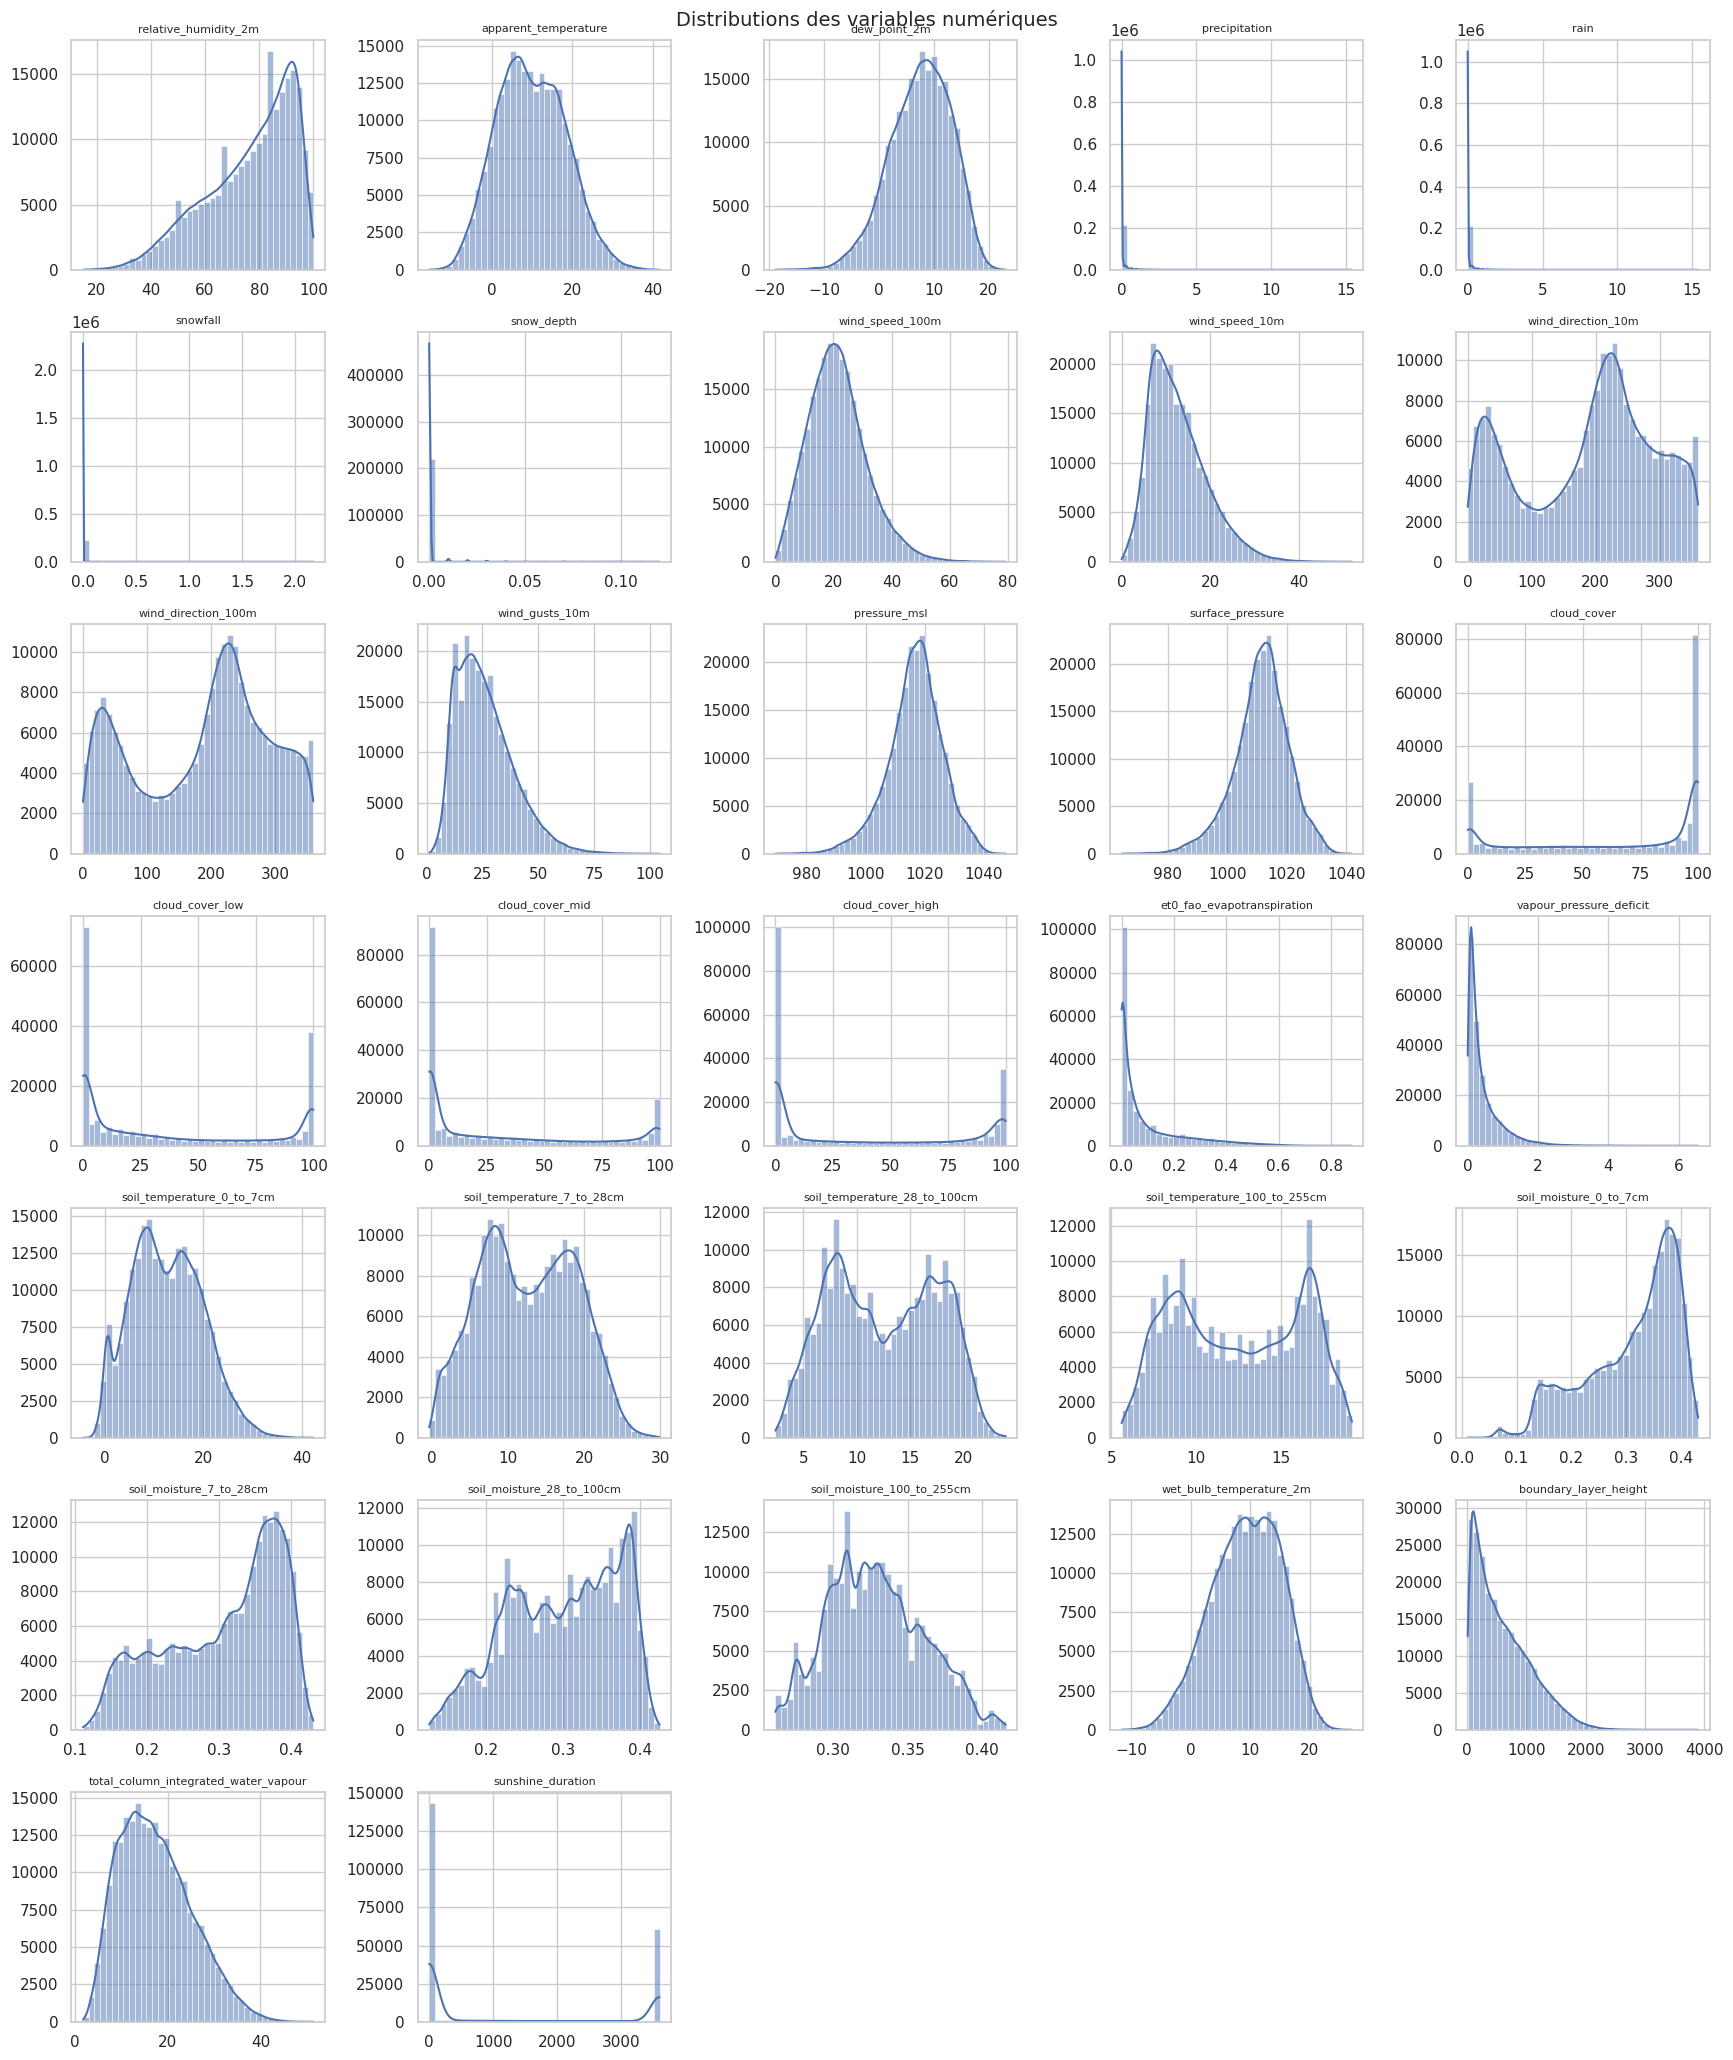

In [33]:
def plot_variable_distributions(df, columns, cols=5, bins=40):
    import math
    rows = math.ceil(len(columns) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3.5, rows*3))
    axes = axes.flatten()
    
    for i, c in enumerate(columns):
        sns.histplot(df[c], bins=bins, kde=True, ax=axes[i])
        axes[i].set_title(c, fontsize=8)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')
    
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    fig.suptitle('Distributions des variables numériques', fontsize=14)
    plt.tight_layout()
    plt.show()

plot_variable_distributions(df, num_cols)



 L’étude des distributions met en évidence plusieurs comportements distincts selon les familles de variables :



     - Températures et humidité : distributions globalement centrées et plausibles : 

         * relative_humidity_2m : valeurs élevées (moy. ≈ 76 %), légèrement asymétriques vers la gauche → une standardisation suffira.

         * apparent_temperature et dew_point_2m : asymétrie légère vers la droite, indiquant quelques valeurs chaudes extrêmes.



     - Précipitations et neige : distributions fortement creuses avec une majorité de zéros (≈ 85 % pour la pluie, 99 % pour la neige) :

         * Ces variables sont très déséquilibrées ; il sera pertinent de créer des indicateurs binaires (rain>0, snow>0) ou des cumulatifs (pluie sur 3/6/12 h).



     - Vent : vitesses (wind_speed_10m, wind_speed_100m, wind_gusts_10m) très asymétriques vers la droite : 

         * Une transformation logarithmique (log(x+1) ou racine carrée) permettra de réduire l’effet des valeurs extrêmes.

         * Les directions de vent (10 m / 100 m) sont angulaires → elles seront converties en coordonnées cycliques (sin(θ), cos(θ)) pour éviter la discontinuité entre 0° et 359°.



     - Nuages et ensoleillement : distributions bimodales, concentrées sur des régimes “dégagé” et “couvert” : 

         * cloud_cover_* et sunshine_duration pourront être normalisées (0–1) ou regroupées en catégories de régime (ex. faible / partiel / fort).



     - Paramètres atmosphériques :

         * vapour_pressure_deficit, et0_fao_evapotranspiration, boundary_layer_height présentent une forte asymétrie positive → transformation logarithmique recommandée.

         * total_column_integrated_water_vapour : asymétrie modérée → standardisation suffisante.



     - Sol (températures et humidité) : distributions stables et peu biaisées, avec une variabilité qui diminue en profondeur : 

         * Une mise à l’échelle standard (z-score ou min–max) est appropriée sans transformation non linéaire.



 En résumé, les principales transformations à prévoir sont :

 log(x+1) sur variables très asymétriques (vent, précipitations, VPD, BLH, etc.), encodage cyclique pour les directions de vent, binarisation ou agrégation des précipitations/neige, standardisation/normalisation des autres variables continues.

 Ces choix permettront d’obtenir des variables plus homogènes et mieux adaptées aux algorithmes sensibles aux distributions (régressions, réseaux de neurones, etc.), tout en préservant la lecture physique des phénomènes météorologiques.

 # Analyse des valeurs aberrantes avec les Boxplots

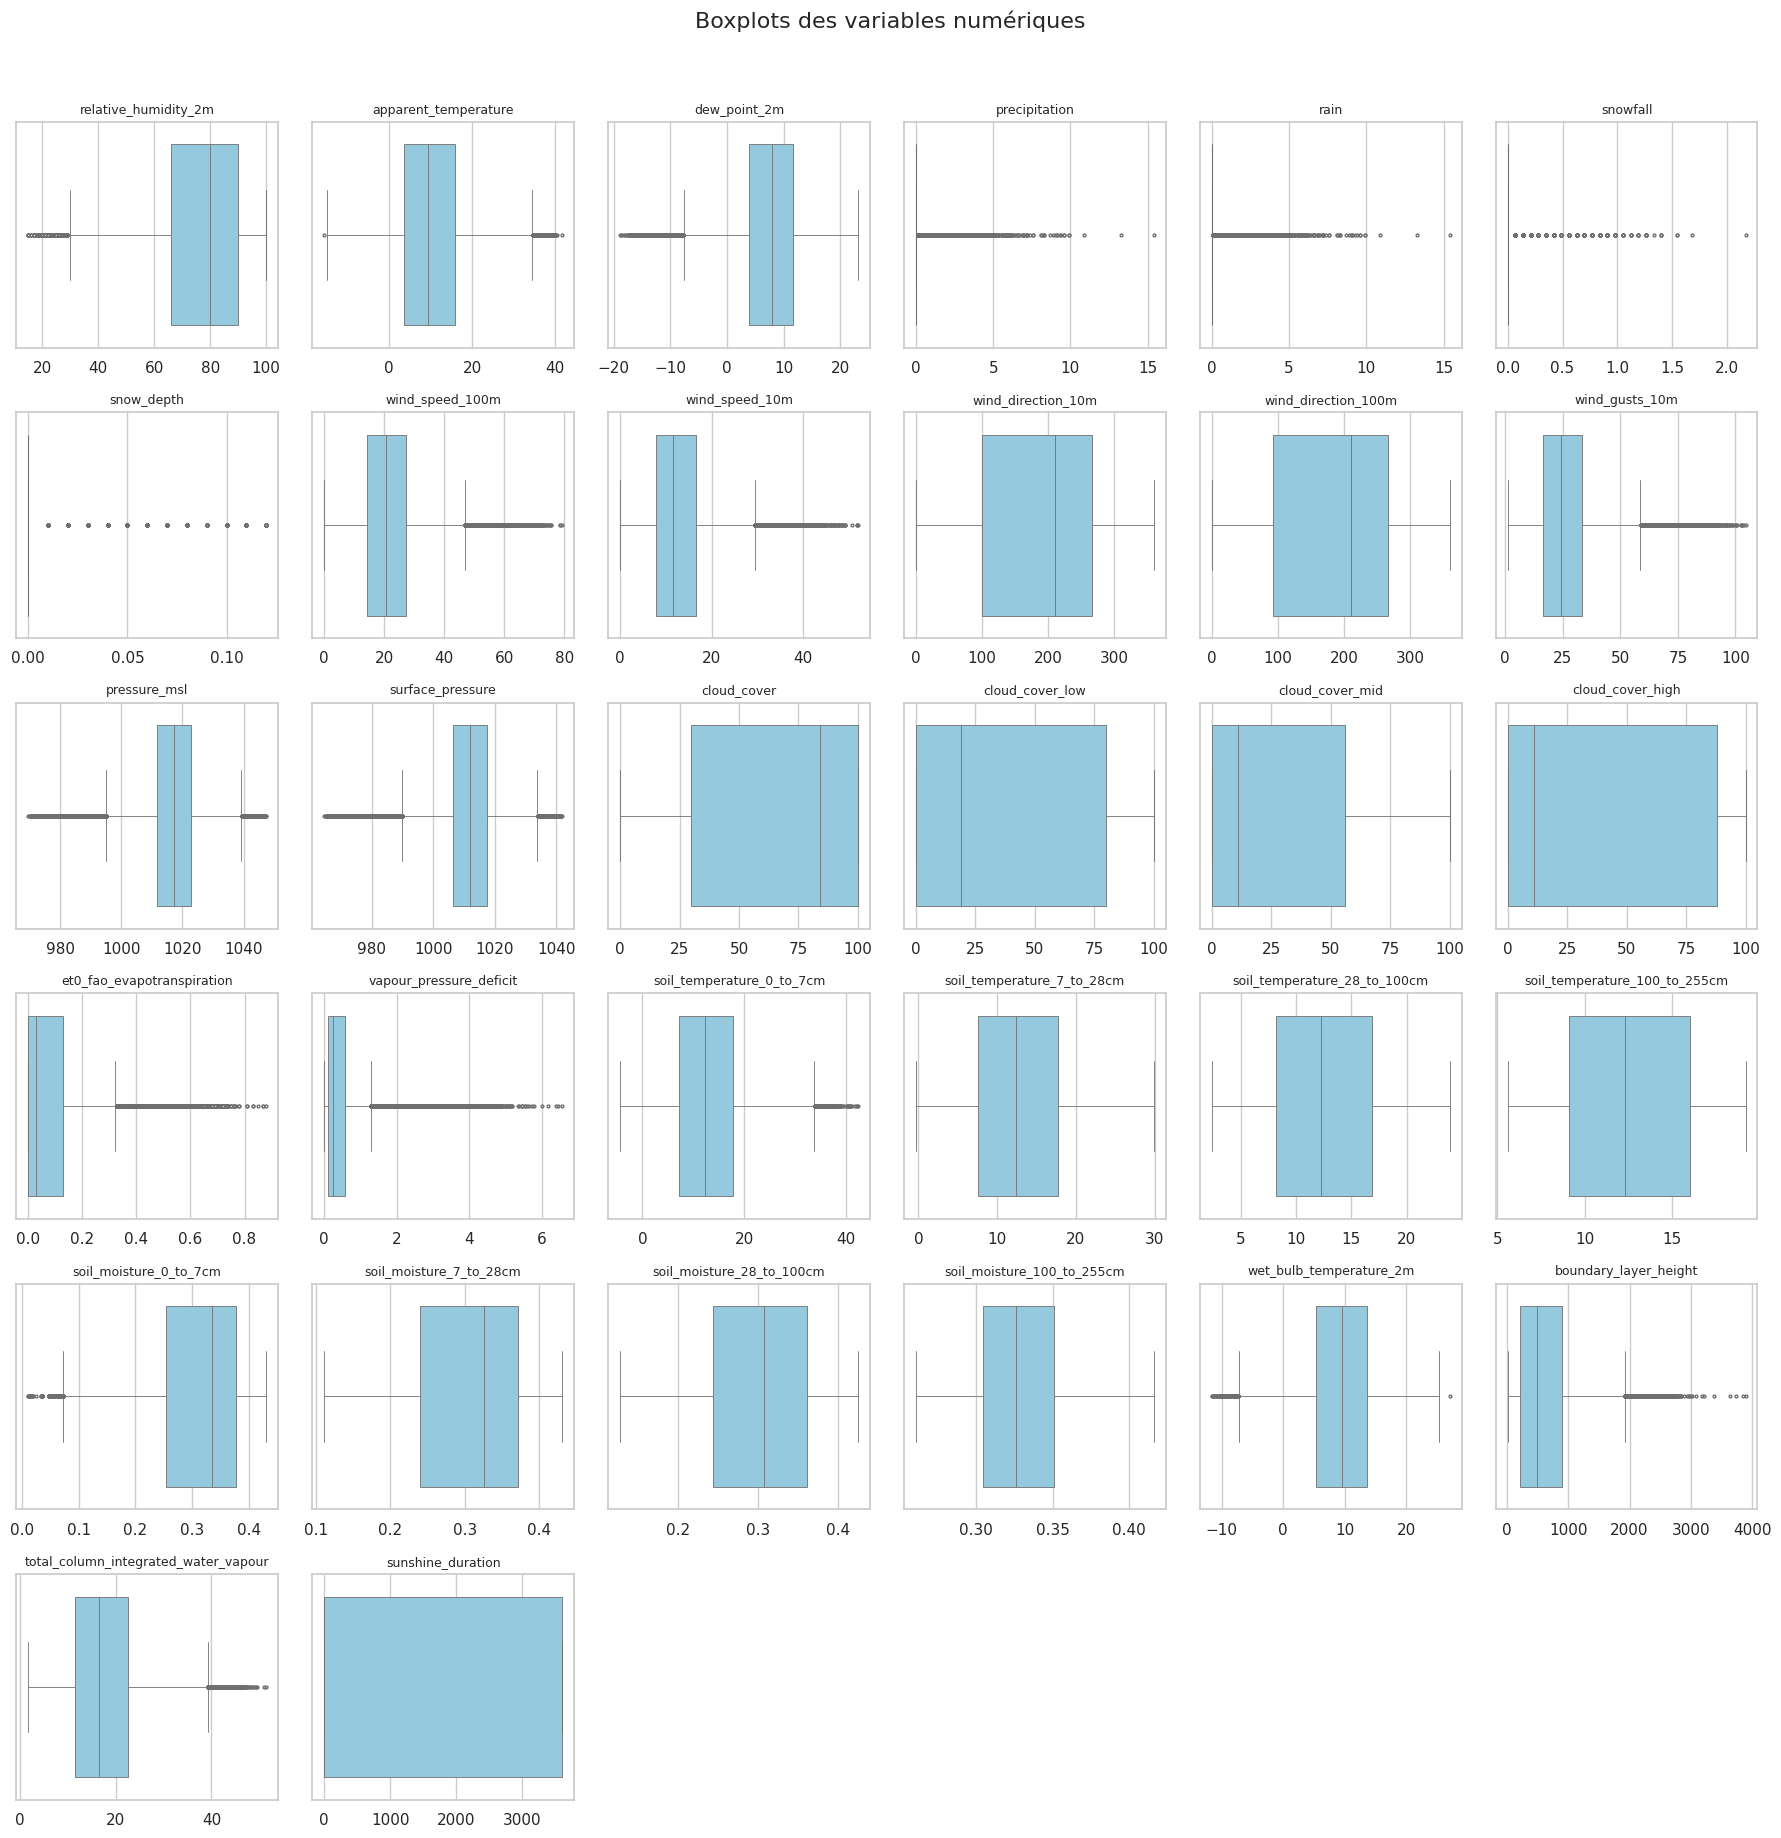

In [34]:
n = len(num_cols)
cols = 6                              
rows = int(np.ceil(n / cols))         

fig, axes = plt.subplots(rows, cols, figsize=(18, 18))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.boxplot(x=df[col], ax=axes[i], color="skyblue", fliersize=2, linewidth=0.6)
    axes[i].set_title(col, fontsize=9)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    
# Supprimer les sous-graphiques vides
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle('Boxplots des variables numériques', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


 Les boxplots confirment les tendances déjà observées sur les distributions des variables :



     - La plupart des variables présentent une dispersion cohérente avec la variabilité météorologique normale.

     - Certaines variables, comme les vitesses de vent, les précipitations, la durée d’ensoleillement ou la hauteur de la couche limite atmosphérique, montrent quelques valeurs extrêmes isolées. Ces points correspondent à des événements climatiques réels (rafales, averses, canicules, etc.) et non à des erreurs de mesure.

     - Les variables liées au sol (températures et humidité) apparaissent plus stables et sans outliers notables.



 Aucune donnée ne semble aberrante ni incohérente : ces valeurs extrêmes seront donc conservées.

 Elles pourront toutefois être encadrées au moment du feature engineering, par des transformations logarithmiques (log(x+1)), un encodage binaire (ex. pluie / pas de pluie) ou un capping léger,  afin de limiter leur influence sur les modèles sensibles aux valeurs extrêmes.

 # Corrélation des variables avec la cible temperature_2m

temperature_2m                          1.000000
apparent_temperature                    0.988635
soil_temperature_0_to_7cm               0.977001
wet_bulb_temperature_2m                 0.964210
soil_temperature_7_to_28cm              0.887182
dew_point_2m                            0.849685
soil_temperature_28_to_100cm            0.781438
vapour_pressure_deficit                 0.771244
total_column_integrated_water_vapour    0.728010
et0_fao_evapotranspiration              0.639196
sunshine_duration                       0.421886
soil_temperature_100_to_255cm           0.410383
boundary_layer_height                   0.379364
wind_gusts_10m                          0.078993
cloud_cover_high                        0.048505
wind_direction_100m                     0.041535
wind_direction_10m                      0.038632
rain                                    0.031753
precipitation                           0.023292
cloud_cover_mid                         0.007062
soil_moisture_100_to

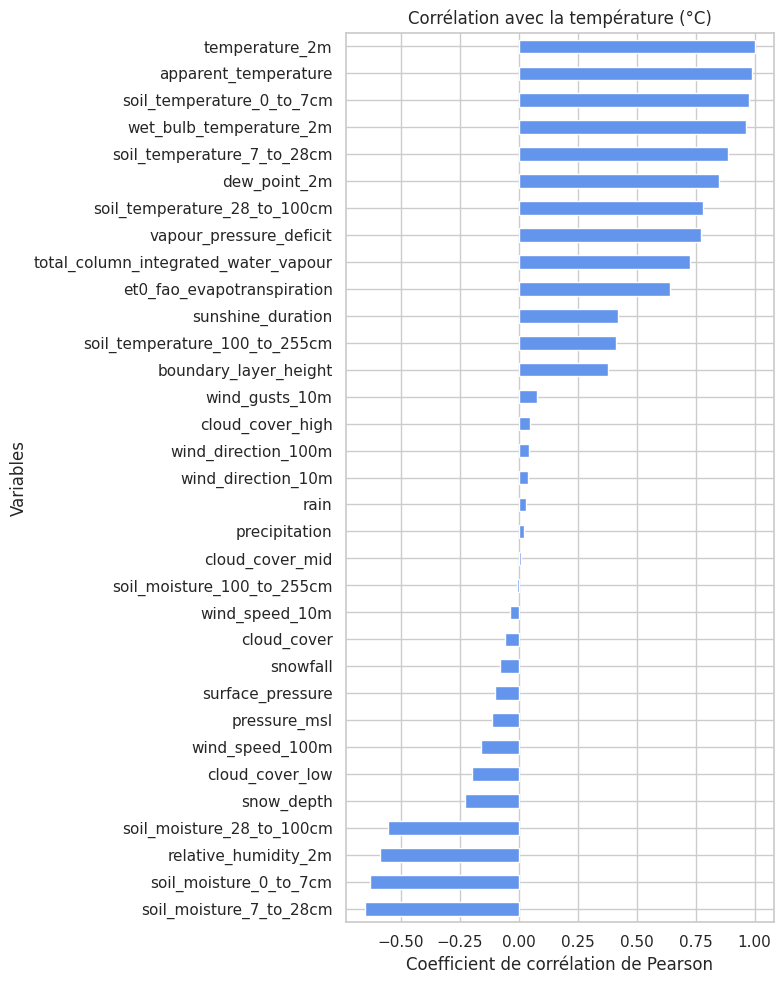

In [35]:
corr_matrix = df[num_cols + ['temperature_2m']].corr()
corr_with_target = corr_matrix['temperature_2m'].sort_values(ascending=False)
display(corr_with_target)
plt.figure(figsize=(8,10))
corr_with_target.sort_values().plot(kind='barh', color='cornflowerblue')
plt.title('Corrélation avec la température (°C)')
plt.xlabel('Coefficient de corrélation de Pearson')
plt.ylabel('Variables')
plt.tight_layout()
plt.show()


 - Corrélations positives fortes :



     * Les variables les plus corrélées sont apparent_temperature, wet_bulb_temperature_2m, dew_point_2m et les températures du sol (soil_temperature_*).

     * Ces variables traduisent directement la chaleur ressentie ou la diffusion thermique du sol → corrélation très élevée (r > 0.85).

     * vapour_pressure_deficit, total_column_integrated_water_vapour et et0_fao_evapotranspiration montrent aussi une relation positive nette avec la température : plus l’air est chaud et sec, plus ces paramètres augmentent.

     * sunshine_duration et boundary_layer_height sont également positivement liées à la température, reflétant la dynamique diurne et les conditions d’ensoleillement.



 - Corrélations négatives :



     * L’humidité relative (relative_humidity_2m) et les humidités du sol (soil_moisture_*) présentent des corrélations négatives marquées : plus la température est élevée, plus l’air et le sol tendent à être secs.

     * Les pressions et certaines mesures de couverture nuageuse sont légèrement négatives, indiquant un effet de compensation (temps chaud souvent associé à pression plus basse ou ciel plus dégagé).



 - Corrélations faibles ou neutres :



     * Les variables de vent et de précipitations présentent des corrélations proches de zéro : leur influence sur la température n’est pas linéaire (effets locaux, saisonniers ou indirects).



 Interprétation et implications : 

     - Les variables thermiques et hydriques expliquent l’essentiel de la variance de la température, certaines sont très redondantes (ex. apparent_temperature, dew_point, températures du sol) → À regrouper ou réduire (éviter redondance) 

     - Les variables négativement corrélées (humidité, sol) apportent une information complémentaire précieuse sur les échanges énergétiques --> À conserver : complément d’information 

     - Les variables neutres (vent, pluie, pression) restent intéressantes pour les modèles non linéaires (ex. arbres de décision, réseaux de neurones) même si leur corrélation linéaire est faible

 # Visualisation des corrélations entre les variables

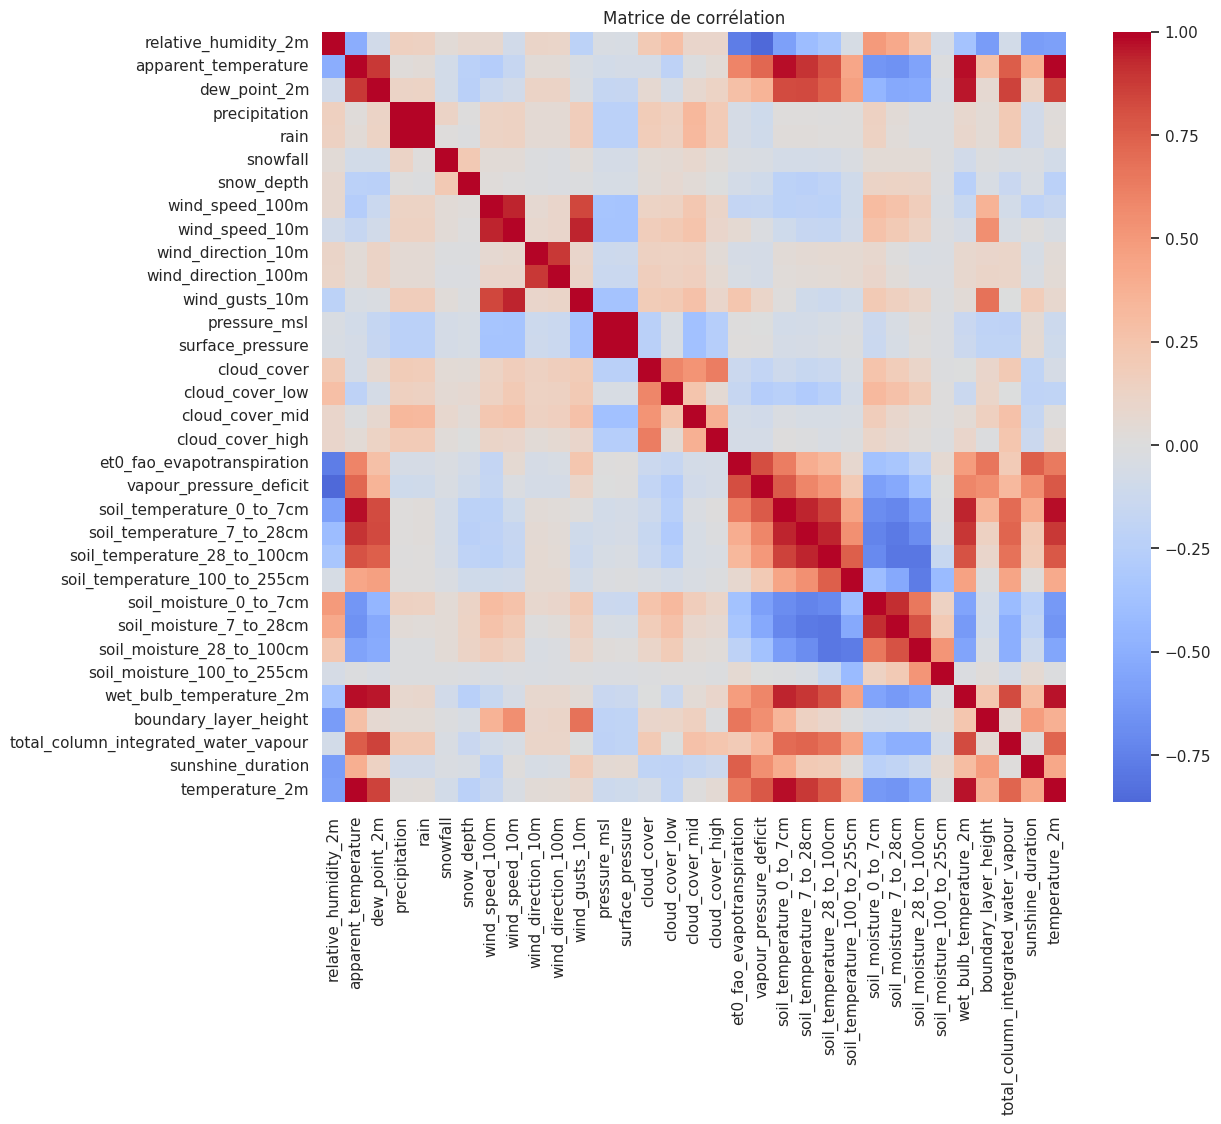

In [36]:
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title("Matrice de corrélation")
plt.show()


 Cette heatmap met en évidence plusieurs blocs fortement corrélés correspondant à des familles physiques cohérentes :



     1. Groupe “température” :

         * temperature_2m, apparent_temperature, wet_bulb_temperature_2m, dew_point_2m et les températures du sol (soil_temperature_*) forment un noyau très corrélé (r > 0.9).

         * Ces variables décrivent la même dynamique thermique à différentes profondeurs ou altitudes.

         * Il faudra éviter de toutes les garder en même temps pour prévenir la multicolinéarité.



     2. Groupe “humidité et vapeur d’eau” :

         * relative_humidity_2m est négativement corrélée avec les variables thermiques et positivement liée à soil_moisture_*.

         * vapour_pressure_deficit et total_column_integrated_water_vapour montrent une relation inverse : le VPD augmente quand l’air se réchauffe et s’assèche, la vapeur d’eau totale suit la température (air chaud retient plus de vapeur).

         * Ces interactions reflètent fidèlement les échanges thermodynamiques air–eau.



     3. Groupe “sol et humidité du sol” :

         * Les quatre variables soil_moisture_* (selon la profondeur) sont très corrélées entre elles (r > 0.8).

         * Une seule profondeur représentative (ex. 0_to_7cm ou moyenne des couches) pourrait suffire pour la modélisation.



     4. Groupe “radiation, évapotranspiration et ensoleillement” :

         * et0_fao_evapotranspiration, sunshine_duration, boundary_layer_height et vapour_pressure_deficit sont corrélées positivement : journées chaudes et ensoleillées.

         * Ce groupe capte l’intensité du rayonnement et l’activité énergétique de l’atmosphère.



     5. Groupe “vent, précipitations et nuages” :

         * Les vitesses de vent (wind_speed_*, wind_gusts_10m) sont modérément corrélées entre elles (r ≈ 0.5–0.7).

         * Les directions (wind_direction_*) sont faiblement corrélées, ce qui est logique pour des angles.

         * Les nuages (cloud_cover_*) sont corrélés entre eux, et négativement avec sunshine_duration.

         * Les précipitations et la neige sont très corrélées entre elles (conditions pluvieuses ou neigeuses partagées).





 Conclusion et implications :

     - Le dataset présente des corrélations logiques et cohérentes avec la physique du climat.

     - Plusieurs groupes redondants sont identifiés : températures de l’air et du sol, humidités du sol, variables de vent, couverture nuageuse.

     - Pour la modélisation, il sera utile de : réduire la dimension (par sélection ou moyenne des variables redondantes), conserver au moins une variable par groupe physique, vérifier la multicolinéarité.



# Analyse des Séries Temporelles

Cette section est dédiée à l'analyse exploratoire (EDA) de nos données en se focalisant sur les propriétés spécifiques aux séries temporelles. L'objectif est de sonder les dynamiques temporelles qui serviront de fondement indispensable pour notre future étape de modélisation.

Nous allons donc analyser et interpréter une série de graphiques et de sorties statistiques. Ces analyses sont conçues pour caractériser la structure de nos données et incluront un examen détaillé de la tendance, de la saisonnalité, de l'autocorrélation et les résultats de tests statistiques fondamentaux, notamment ceux de la stationnarité ou autre.

## 1. Vue d'ensemble de la série temporelle

Le graphique suivant représente l'évolution de la température à Paris sur une période de 25 ans, de 2000 à 2025 : 

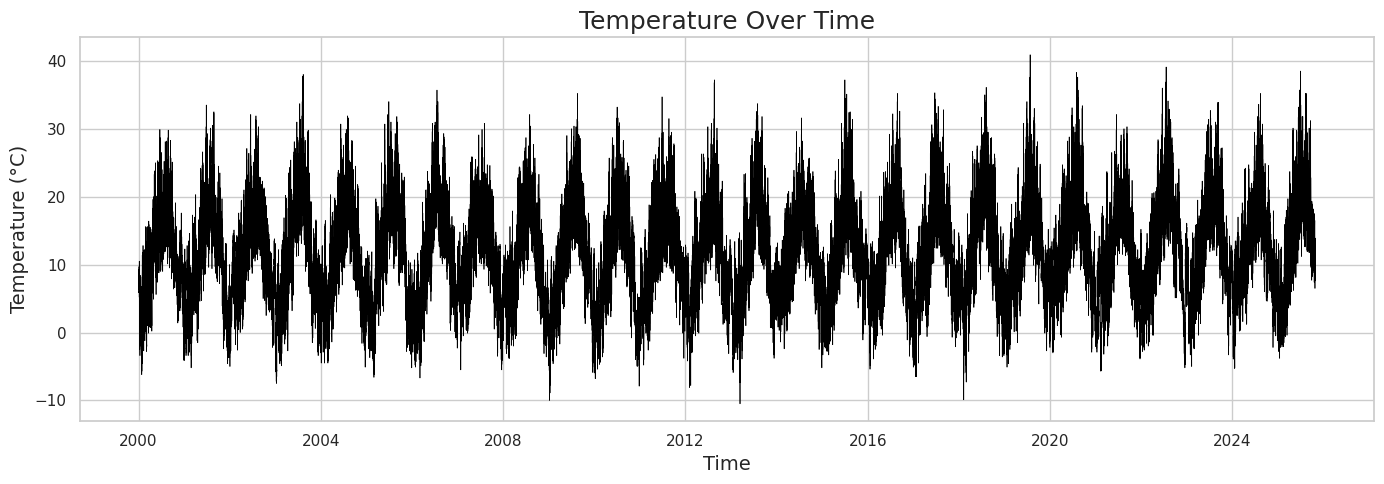

In [37]:
plt.figure(figsize=(14, 5))
sns.lineplot(
    x="time", 
    y="temperature_2m", 
    data=df,
    color="black",           
    linewidth=0.5,                         
)

plt.title("Temperature Over Time", fontsize=18)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Temperature (°C)", fontsize=14)

plt.tight_layout()
plt.show()

L'inspection visuelle révèle immédiatement une saisonnalité annuelle très prononcée et régulière, qui est la caractéristique dominante de cette série temporelle. Les températures suivent un cycle annuel systématique, avec des pics durant les mois d'été et des creux durant les mois d'hiver. Cette oscillation saisonnière est de forte amplitude et se répète avec une grande régularité sur l'ensemble des deux décennies.

En plus de ce cycle saisonnier, la série présente une forte volatilité à haute fréquence, visible par les "dents de scie" rapides de la courbe. Celles-ci représentent les fluctuations météorologiques quotidiennes, qui se superposent au schéma saisonnier de base. On note également la présence d'événements extrêmes, tels que des pics caniculaires et des vagues de froid, qui se manifestent par des dépassements notables de l'amplitude saisonnière moyenne.

Concernant la tendance à long terme (par exemple, un réchauffement ou un refroidissement sur 25 ans), elle n'est pas visuellement évidente à ce stade. Elle est potentiellement masquée par la forte variance saisonnière et la volatilité à court terme.

Ce premier graphique temporel confirme la nature cyclique et volatile des données. Une analyse plus détaillée et une décomposition formelle de la série en ses différentes composantes – tendance, saisonnalité et résidus – seront effectuées dans la suite de ce notebook pour quantifier ces observations.

## 2. Analyse des profils saisonniers

Le graphique suivant, de type "profil saisonnier", superpose les courbes de température moyenne mensuelle pour différentes années :

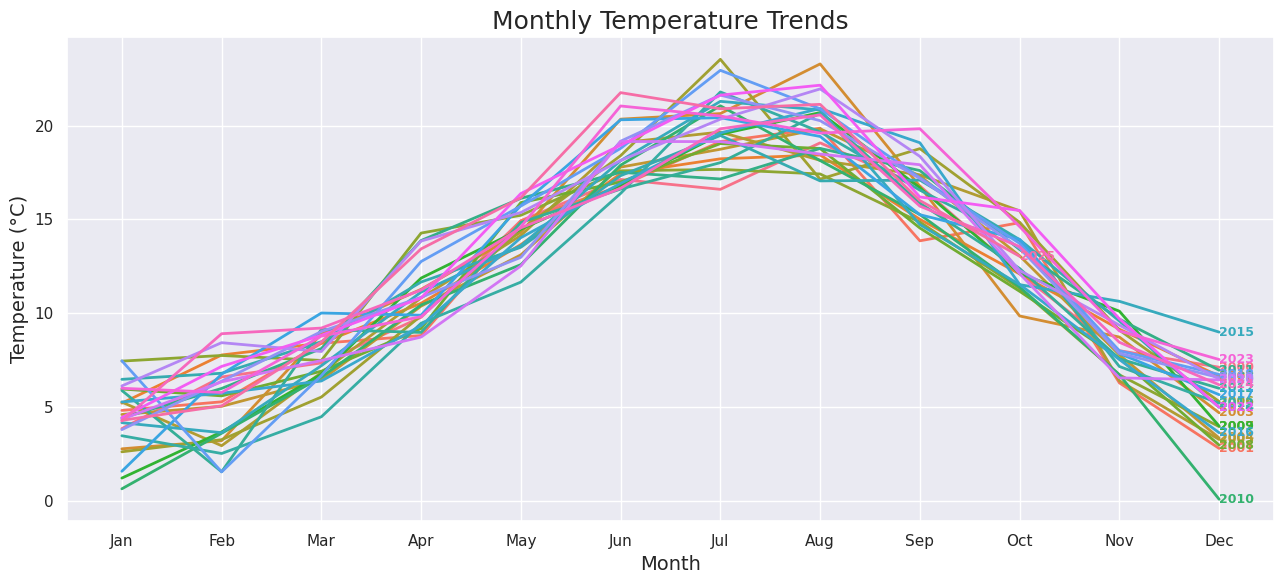

In [38]:
# Extract year and month from the index
df['year'] = df.index.year
df['month'] = df.index.month
df['month_name'] = df['month'].apply(lambda x: month_abbr[x])

# Compute monthly averages per year
monthly = (
    df.groupby(['year', 'month_name'], sort=False)['temperature_2m']
      .mean()
      .reset_index()
)

# Ensure month order (Jan → Dec)
month_order = list(month_abbr)[1:]  # ['Jan', 'Feb', ..., 'Dec']
monthly['month_name'] = pd.Categorical(monthly['month_name'], categories=month_order, ordered=True)


sns.set_theme(style="darkgrid")
plt.figure(figsize=(13, 6))

palette = sns.color_palette("husl", n_colors=monthly['year'].nunique())

# Plot the seasonal lines
sns.lineplot(
    data=monthly,
    x='month_name', y='temperature_2m', hue='year',
    palette=palette, linewidth=2
)


for i, (year, subset) in enumerate(monthly.groupby('year')):
    plt.text(
        x=subset['month_name'].iloc[-1],
        y=subset['temperature_2m'].iloc[-1],
        s=str(year),
        color=palette[i],
        fontsize=9,
        fontweight='bold',
        va='center'
    )

plt.title("Monthly Temperature Trends", fontsize=18)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Temperature (°C)", fontsize=14)
plt.legend([],[], frameon=False)
plt.tight_layout()
plt.show()

Ce graphique offre une vue plus détaillée de la saisonnalité observée précédemment. Il confirme de manière éclatante le cycle saisonnier annuel comme étant le moteur principal des températures. Toutes les années, sans exception, suivent le même schéma : une augmentation de la température du début d'année jusqu'à un pic estival (situé en juillet ou août), suivie d'une diminution jusqu'en décembre.

L'apport principal de ce visuel est de mettre en évidence la variabilité interannuelle. Si le profil saisonnier est constant, son intensité varie considérablement d'une année à l'autre. On observe un "faisceau" de courbes, montrant que :

    1. La variabilité des pics estivaux est forte : Certains étés sont notablement plus chauds (courbes du haut, dépassant 22°C en moyenne mensuelle), tandis que d'autres sont plus frais (courbes du bas, peinant à atteindre 17°C).

    2. La variabilité hivernale est également présente : Les mois de janvier et février montrent un écart de plusieurs degrés entre les hivers les plus froids (proches de 0°C) et les plus doux (autour de 7°C).

    3. Les mois de transition (printemps et automne) voient les courbes se croiser fréquemment, illustrant des différences dans la rapidité de l'installation ou de la fin des saisons.

En synthèse, ce graphique décompose la volatilité totale observée dans le premier graphique. Il sépare le schéma saisonnier commun de la variation interannuelle. Il sera donc crucial pour l'analyse de quantifier cette variance interannuelle et de comprendre si elle est purement aléatoire ou si elle est liée à d'autres facteurs ou cycles de plus long terme.

## 3. Évolution interannuelle par mois

Le graphique en panneaux suivant décompose l'analyse saisonnière en présentant douze mini-graphiques, un pour chaque mois de l'année. Chaque panneau individuel montre l'évolution de la température moyenne pour un mois spécifique.

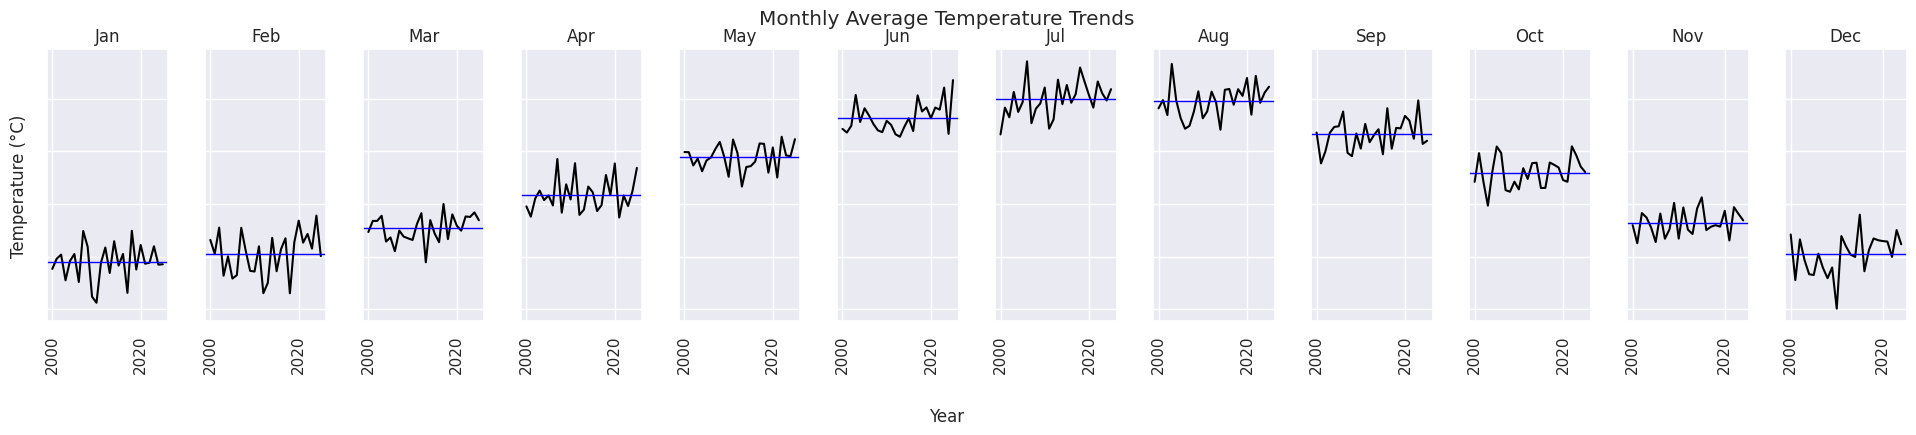

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=12, figsize=(24, 4), sharey=True)

for i, month in enumerate(month_order):
    month_data = monthly[monthly['month_name'] == month]
    if month_data.empty:
        axes[i].set_visible(False)
        continue

    mean_temp = month_data['temperature_2m'].mean()

    # Plot temperature per year for this month
    axes[i].plot(month_data['year'], month_data['temperature_2m'], color='black')
    # Plot average line
    axes[i].axhline(mean_temp, color='blue', linestyle='-', linewidth=1, label='Average')

    axes[i].set_title(month)
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', rotation=90)

    if i == 0:
        axes[i].set_ylabel('Temperature (°C)')
    else:
        axes[i].set_yticklabels([])

fig.suptitle('Monthly Average Temperature Trends')
fig.text(0.5, -0.05, 'Year', ha='center')
fig.subplots_adjust(wspace=0.3, bottom=0.2)

plt.show()

L'objectif de cette visualisation était d'isoler la variabilité interannuelle et de rechercher une tendance de fond, en supprimant l'effet du cycle saisonnier principal.

L'observation la plus notable est l'absence d'une tendance linéaire claire et uniforme. Dans la plupart des panneaux, la température moyenne du mois oscille de manière significative autour de la moyenne à long terme sans montrer d'augmentation ou de diminution systématique.

Ce qui est mis en évidence est l'importante variabilité interannuelle. Pour n'importe quel mois donné (par exemple, juillet), certaines années sont nettement plus chaudes que la moyenne de juillet, tandis que d'autres sont nettement plus fraîches. Cette visualisation confirme que la "dispersion" observée dans le graphique précédent (le faisceau de courbes) n'est pas un bruit aléatoire uniforme, mais une fluctuation annuelle significative. Cela suggère la présence de cycles ou de variations de plus basse fréquence (pluriannuels) qui influencent les températures, en plus du cycle saisonnier annuel.

## 4. Identification du cycle diurne

Le graphique suivant superpose les profils de température de nombreuses journées individuelles où l'axe X représente le temps sur un cycle de 24 heures :

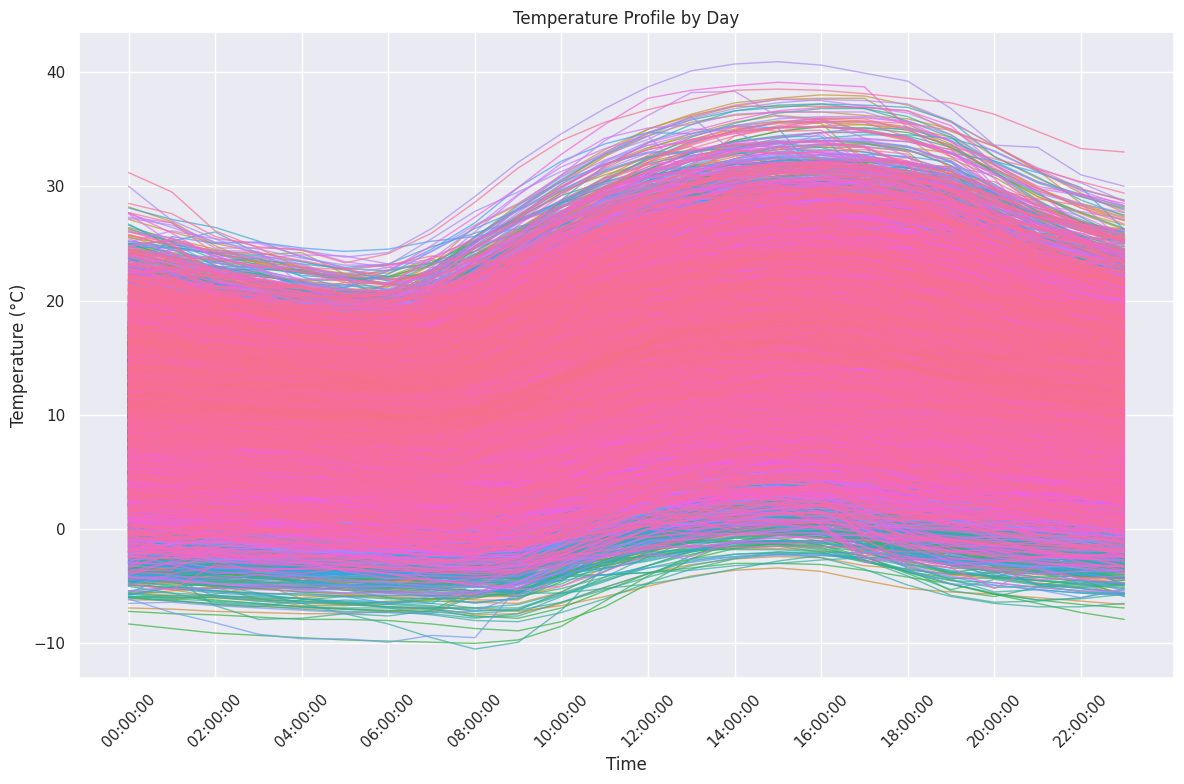

In [40]:
df["hour-minute"] = df.index.strftime("%H:%M:%S")
df["day"] = df.index.date

# Plot
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(
    data=df,
    x="hour-minute",
    y="temperature_2m",
    hue="day",
    palette="husl",
    legend=False,
    ax=ax,
    linewidth=1,
    alpha=0.7
)


unique_ticks = df["hour-minute"].unique()
ticks_to_plot = unique_ticks[::2]  
ax.set_xticks(range(0, len(unique_ticks), 2))
ax.set_xticklabels(ticks_to_plot, rotation=45)

ax.set_title("Temperature Profile by Day")
ax.set_xlabel("Time")
ax.set_ylabel("Temperature (°C)")

plt.tight_layout()
plt.show()

Cette visualisation met en évidence un second cycle fondamental : le cycle diurne (journalier), qui s'ajoute au cycle annuel déjà identifié. On observe un schéma très net et répété : les températures sont au plus bas tôt le matin (généralement autour de 06h) puis augmentent avec le lever du soleil pour atteindre un pic dans l'après-midi (typiquement entre 14h et 18h), avant de redescendre durant la nuit.

L'élément le plus frappant est l'extrême dispersion verticale des courbes, allant de -10°C à plus de 40°C. Cette dispersion n'est pas aléatoire ; elle est le résultat de la superposition du cycle saisonnier sur le cycle diurne. Les lignes du bas, parfois négatives, représentent les profils des jours d'hiver, tandis que les lignes du haut, dépassant 30°C ou 40°C, correspondent aux jours d'été. Le "cœur" très dense des courbes (en rose) représente la majorité des jours de mi-saison.

En conclusion, ce graphique est essentiel car il confirme que les données de température sont régies par deux cycles imbriqués : un cycle annuel (qui fixe le niveau de température moyen du jour) et un cycle diurne (qui module cette température au fil des heures). On note également que l'amplitude de ce cycle diurne semble elle-même varier en fonction de la saison : les jours d'été (lignes hautes) montrent une "vague" journalière plus ample que les jours d'hiver (lignes basses, qui sont comparativement plus plates).